In [ ]:
include("../finite_difference.jl")
include("../ode_solver.jl")

kappa = 1   # diffusion constant
L = 1.0         # length of spatial domain
T = 0.5         # total time to solve for

function u_I(x)
    # initial temperature distribution
    y = sin.(pi*x/L)
    return y
end

function u_exact(x,t)
    # the exact solution
    y = exp.(-kappa*(pi^2/L^2)*t)*sin.(pi*x/L)
    return y
end

# Set numerical parameters
mx = 10     # number of gridpoints in space
mt = 1000   # number of gridpoints in time


# forward euler Estimate
weird_x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, forward_euler)
# Create trace
f_euler = scatter(x=x, y=u_j, mode="markers", name="forward euler", showlegend=true)


# backward euler Estimate
x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, backward_euler)
# Create trace
b_euler = scatter(x=x, y=u_j, mode="markers", name="backward euler", showlegend=true)


# crank nicholson Estimate
x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, crank_nicholson)
# Create trace
c_nicholson = scatter(x=x, y=u_j, mode="markers", name="crank nicholson", showlegend=true)



# Plot the final result and exact solution
xx = LinRange(0,L,250)

# Create solution trace
exact = scatter(x=xx, y=u_exact(xx,T), mode="lines", name="exact", showlegend=true)

layout = Layout(
    xaxis_title = "x",
    yaxis_title = "u(x,0.5)"
    )

plot([exact, f_euler, b_euler, c_nicholson], layout)

In [52]:
using PlotlyJS
using Test
include("../ode_solver.jl")
include("../numerical_shooting.jl")
include("../examples/example_functions.jl")
include("../visualisation.jl")

# # Plot of ODE for t = 40
# t = 0:0.1:40
# u0 = [-1 0]
# hopf_plot = plot_ode((u, t) -> hopf2d(u, t, beta=1), u0, t, ["x" "y"])
# savefig(hopf_plot, "../output/hopf_plot.png")

# # Plot phase portrait
# hopf_phase_portrait = plot_phase_portrait((u, t) -> hopf2d(u, t, beta=1), u0, t, ["u1" "u2"])
# savefig(hopf_phase_portrait, "../output/hopf_phase_portrait.png")

# # Find limit cycle
# u0, T = find_limit_cycle((u, t) -> hopf2d(u, t, beta=1), [-1 0], 6.28)
# println("u0: ", u0)
# println("Period: ", T)


# # Plot ODE analytic and numerical solutions to see if they match
# t = 0:0.1:T
# u1, u2 = hopf2d_sol(t, beta=1, theta=pi)

# # Numerical solution
# deltat_max = 0.01
# numerical_sol = solve_ode((u, t) -> hopf2d(u, t, beta=1), u0, t, "rk4", deltat_max)
# x = numerical_sol[:,1]
# y = numerical_sol[:,2]
# x_plot = scatter(x=t, y=x, mode="lines", name="u1 - numerical", showlegend=true)
# y_plot = scatter(x=t, y=y, mode="lines", name="u2 - numerical", showlegend=true)

# # Analytic solution
# u1_plot = scatter(x=t, y=u1, mode="lines", name="u1 - analytic", showlegend=true)
# u2_plot = scatter(x=t, y=u2, mode="lines", name="u2 - analytic", showlegend=true)

# layout = Layout(xaxis_title = "time")

# sol_plot = plot([x_plot, y_plot, u1_plot, u2_plot], layout)
# savefig(sol_plot, "../output/sol_plot.png")









x0 = [1]
t = [0, 1]

estimate = solve_ode(f, x0, t, "rk4", 0.001)[end][1]

# println(@test isapprox(estimate, ℯ))
println(@test isapprox(estimate, ℯ))

@test isapprox(estimate, ℯ)


Test Passed
  Expression: isapprox(estimate, ℯ)
   Evaluated: isapprox(2.718281828459023, ℯ)


Test Passed
  Expression: isapprox(estimate, ℯ)
   Evaluated: isapprox(2.718281828459023, ℯ)

In [106]:


@testset "Systems Tests" begin

    @testset "Week 3" begin

        # test if solve_ode estimates a simple ODE correctly
        x0 = [1]
        t = 0:1
        estimate = solve_ode(f, x0, t, "rk4", 0.001)[end][1]
        @test isapprox(estimate, ℯ)
        

        # test if solve_ode estimates systems of ODEs correctly
        x0 = [1 0]
        t = [0, 1]
        f2_solution = hopf2d_sol(t, beta=1, theta=pi) # adjusted for phase
        f2_numerical_sol = solve_ode(hopf2d, u0, t, "rk4")
        @test  all(isapprox.(f2_numerical_sol, hopf_solution, atol=1e-6))

    end

    @testset "Hopf Week 17" begin

        # test if limit cycle matches that analytical solution
        u0, T = find_limit_cycle(hopf2d, [-1 0], 6.28)
        @test isapprox(T, 2*pi)

        # test if solve_ode estimates a Hopf ODE correctly
        t = 0:0.1:T
        hopf_solution = hopf2d_sol(t, beta=1, theta=pi) # adjusted for phase
        hopf_numerical_sol = solve_ode(hopf2d, u0, t, "rk4")
        @test  all(isapprox.(hopf_numerical_sol, hopf_solution, atol=1e-6))




    end

end

Test Summary: | Pass  Total
Systems Tests |    3      3


Test.DefaultTestSet("Systems Tests", Any[Test.DefaultTestSet("Week 3", Any[], 1, false, false), Test.DefaultTestSet("Hopf Week 17", Any[], 2, false, false)], 0, false, false)

In [100]:
u0, T = find_limit_cycle((u, t) -> hopf2d(u, t, beta=1), [-1 0], 6.28)
t = 0:0.1:T
hopf_solution= hopf2d_sol(t, beta=1, theta=pi)
numerical_sol = solve_ode((u, t) -> hopf2d(u, t, beta=1), u0, t, "rk4")

@test  all(isapprox.(numerical_sol, hopf_solution, atol=1e-6))

Test Passed
  Expression: all(isapprox.(numerical_sol, hopf_solution, atol = 1.0e-6))

In [82]:
hopf_solution= hopf2d_sol(0:0.1:20, beta=1, theta=pi)
numerical_sol = solve_ode((u, t) -> hopf2d(u, t, beta=1), u0, 0:0.1:20, "rk4")


all(isapprox.(numerical_sol, hopf_solution, atol=1e-6))

true

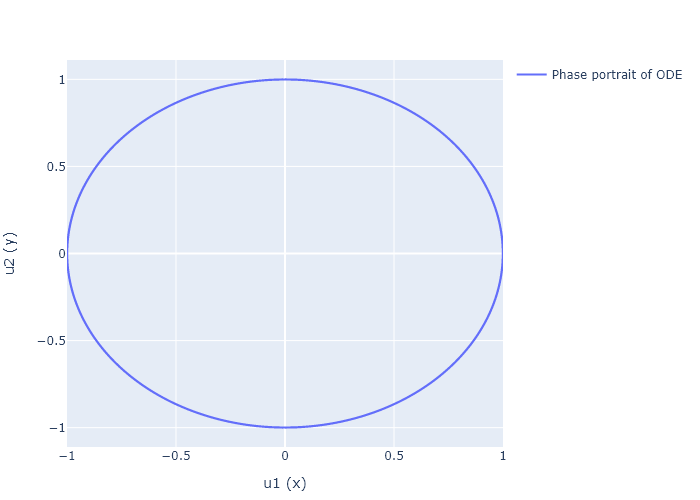

In [94]:
t = 0:0.1:40
u0 = [1 0]
plot_phase_portrait(hopf2d, u0, t, ["u1 (x)" "u2 (y)"])

In [83]:
numerical_sol = solve_ode((u, t) -> hopf2d(u, t, beta=1), u0, 0:0.1:20, "rk4")

201×2 Matrix{Float64}:
 -1.0       -6.9925e-10
 -0.995004  -0.0998334
 -0.980067  -0.198669
 -0.955336  -0.29552
 -0.921061  -0.389418
 -0.877583  -0.479426
 -0.825336  -0.564642
 -0.764842  -0.644218
 -0.696707  -0.717356
 -0.62161   -0.783327
  ⋮         
 -0.93922   -0.343315
 -0.900254  -0.435365
 -0.852292  -0.523066
 -0.795815  -0.60554
 -0.731386  -0.681964
 -0.659649  -0.751573
 -0.581322  -0.813674
 -0.497186  -0.867644
 -0.408082  -0.912945

In [93]:
find_limit_cycle(hopf2d, [1 0], 4*pi)

([1.0 0.0], 12.566370614359172)